# Convolutional Neural Networks

## Project:  Landmark Classification


### Transfer learning



In [1]:
# Install requirements
!pip install -r requirements.txt | grep -v "already satisfied"

  Obtaining dependency information for opencv-python-headless from https://files.pythonhosted.org/packages/9d/d7/e2aaf344254292d2046f9984b54212e4e7d69a57d30ae15e7294840710f6/opencv_python_headless-4.8.1.78-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
  Obtaining dependency information for pytest from https://files.pythonhosted.org/packages/df/d0/e192c4275aecabf74faa1aacd75ef700091913236ec78b1a98f62a2412ee/pytest-7.4.2-py3-none-any.whl.metadata
  Obtaining dependency information for pluggy<2.0,>=0.12 from https://files.pythonhosted.org/packages/05/b8/42ed91898d4784546c5f06c60506400548db3f7a4b3fb441cba4e5c17952/pluggy-1.3.0-py3-none-any.whl.metadata
  Using cached pluggy-1.3.0-py3-none-any.whl.metadata (4.3 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 14.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 324.5/324.5 kB 60.3 MB/s eta 0:00:00
Using cached pluggy-1.3.0-py3-none-any.whl (18 kB)


In [2]:
from src.helpers import setup_env

setup_env()

GPU available
Dataset already downloaded. If you need to re-download, please delete the directory landmark_images
Reusing cached mean and std


---
## Create transfer learning architecture



In [4]:
!pytest -vv src/transfer.py

============================= test session starts ==============================
platform linux -- Python 3.10.12, pytest-7.4.2, pluggy-1.3.0 -- /home/ec2-user/anaconda3/envs/pytorch_p310/bin/python3.10
cachedir: .pytest_cache
rootdir: /home/ec2-user/SageMaker
plugins: anyio-3.7.1
collected 1 item                                                               

src/transfer.py::test_get_model_transfer_learning PASSED                 [100%]

=============================== warnings summary ===============================
src/transfer.py::test_get_model_transfer_learning
  /home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
    warnings.warn(

src/transfer.py::test_get_model_transfer_learning
  /home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarnin

---
##  Train, validation and test



In [ ]:
batch_size = 64  # size of the minibatch for stochastic gradient descent (or Adam)
valid_size = 0.2  # fraction of the training data to reserve for validation
num_epochs = 50  # number of epochs for training
num_classes = 50  # number of classes. 
learning_rate = 0.001  # Learning rate for SGD (or Adam)
opt = 'adam'      # optimizer. 'sgd' or 'adam'
weight_decay = 0.0 # regularization. 

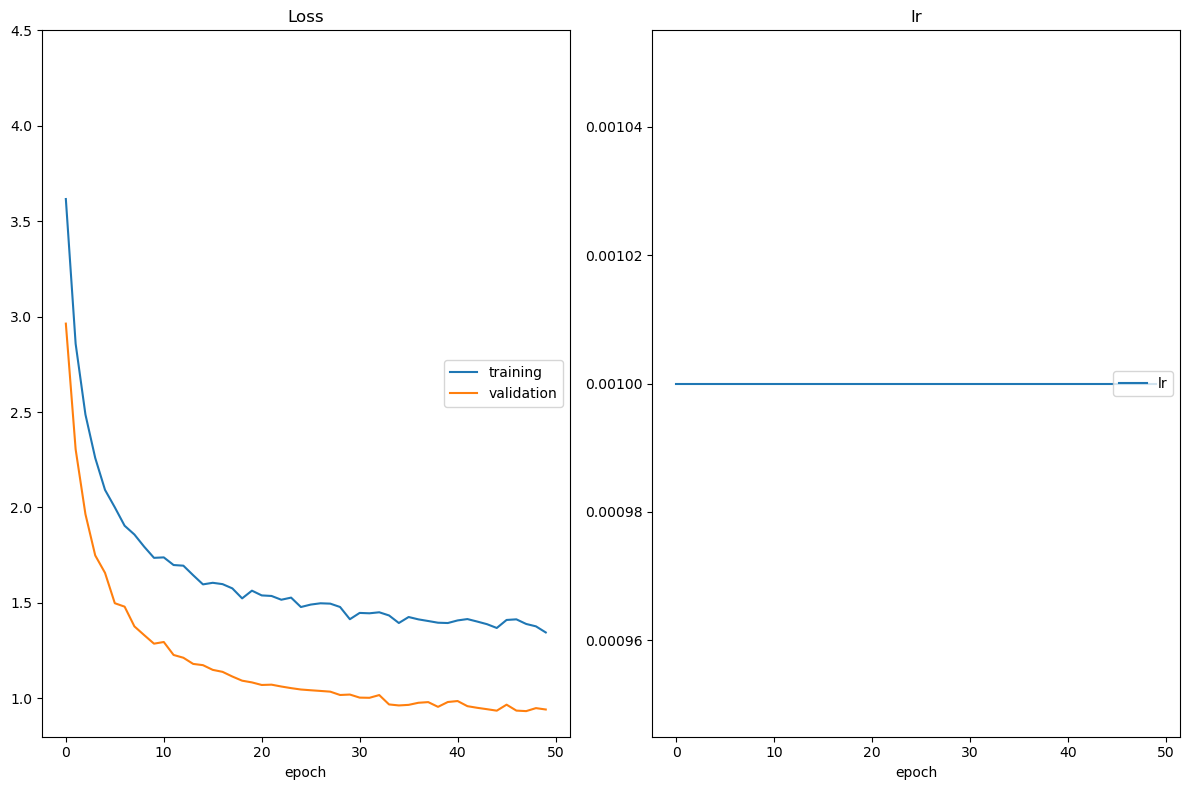

In [8]:
from src.data import get_data_loaders
from src.optimization import get_optimizer, get_loss
from src.train import optimize
from src.transfer import get_model_transfer_learning

model_transfer = get_model_transfer_learning(model_name="resnet18", n_classes=num_classes)

# train the model
data_loaders = get_data_loaders(batch_size=batch_size)
optimizer = get_optimizer(
    model_transfer,
    learning_rate=learning_rate,
    optimizer=opt,
    weight_decay=weight_decay,
)
loss = get_loss()

optimize(
    data_loaders,
    model_transfer,
    optimizer,
    loss,
    n_epochs=num_epochs,
    save_path="checkpoints/model_transfer.pt",
    interactive_tracking=True
)

---
##  Test the Model



In [9]:
import torch
from src.train import one_epoch_test
from src.transfer import get_model_transfer_learning

model_transfer = get_model_transfer_learning("resnet18", n_classes=num_classes)
# Load saved weights
model_transfer.load_state_dict(torch.load('checkpoints/model_transfer.pt'))

one_epoch_test(data_loaders['test'], model_transfer, loss)

Testing: 100%|██████████████████████████████████| 20/20 [00:25<00:00,  1.29s/it]

Test Loss: 1.254467


Test Accuracy: 67% (842/1250)


1.2544665440917016

---
## <img src="static_images/icons/noun-advance-2109145.png" alt=">" style="width:50px"/> Step 4: Export using torchscript

Now, just like we did with our original model, we export the best fit model using torchscript so that it can be used in our application:

In [10]:
from src.predictor import Predictor
from src.helpers import compute_mean_and_std

#  get the class names from our data loaders
class_names = data_loaders["train"].dataset.classes


model_transfer = model_transfer.cpu()

model_transfer.load_state_dict(
    torch.load("checkpoints/model_transfer.pt", map_location="cpu")
)

# wrapping the model using the predictor class
mean, std = compute_mean_and_std()
predictor = Predictor(model_transfer, class_names, mean, std).cpu()

# Export using torch.jit.script
scripted_predictor = torch.jit.script(predictor)
scripted_predictor.save("checkpoints/transfer_exported.pt")

Reusing cached mean and std


In [ ]:
import torch
from src.predictor import predictor_test
from src.helpers import plot_confusion_matrix

model_reloaded = torch.jit.load("checkpoints/transfer_exported.pt")

pred, truth = predictor_test(data_loaders['test'], model_reloaded)

plot_confusion_matrix(pred, truth)

  0%|                                          | 1/1250 [00:00<08:01,  2.60it/s]/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/torch/nn/modules/module.py:1501: UserWarning: operator() profile_node %388 : int = prim::profile_ivalue(%out_dtype.1)
 does not have profile information (Triggered internally at /opt/conda/conda-bld/pytorch_1686274778240/work/third_party/nvfuser/csrc/graph_fuser.cpp:104.)
  return forward_call(*args, **kwargs)
code/__torch__/torchvision/transforms/functional.py:188: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This

Accuracy: 0.7032
